Reference: https://medium.com/ai-techsystems/fingerprint-pattern-classification-using-deep-learning-9eb93757df11
           https://github.com/amr3499/CSEC-472-Biometrics-Lab/tree/main           

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from random import shuffle

In [2]:
dir = 'dataset'
labels = []
img_names = []
img_paths = []
gender = []

for subdir, dirs, files in os.walk('dataset'):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(subdir, file), 'r') as t:
                content = t.readlines()
                gender.append(content[0].rsplit(' ')[1][0])
                img_name = content[2].rsplit(' ')[1][:-4] + '.png'
                img_paths.append(os.path.join(subdir, img_name))
                img_names.append(img_name)
                labels.append((content[1].rsplit(' ')[1][0]))           
df = pd.DataFrame()
df['IMAGE PATH'] = img_paths
df['IMAGE NAME'] = img_names
df['LABEL'] = labels
df['GENDER'] = gender

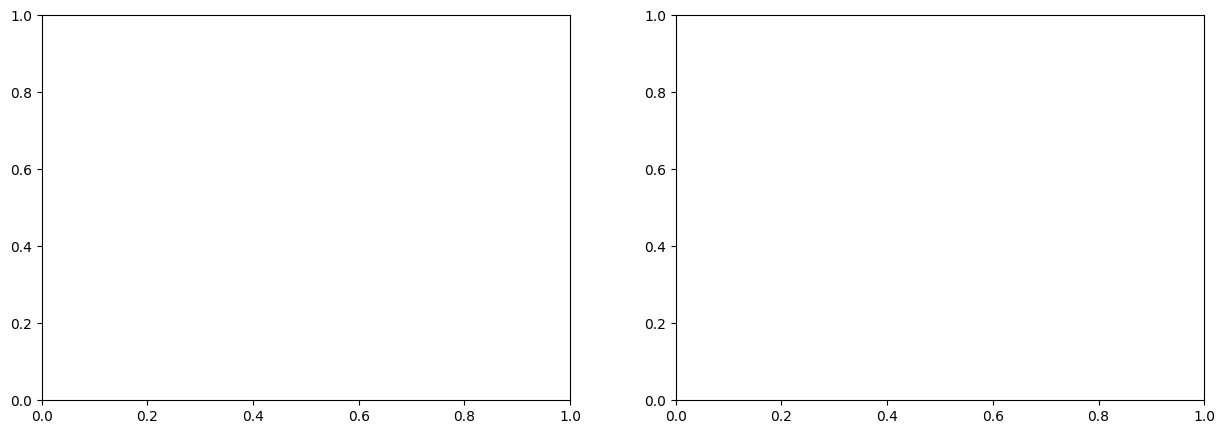

In [3]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(ax=axes[0], data = df, x = 'LABEL')
sns.countplot(ax=axes[1], data = df, x = 'LABEL', hue = 'GENDER')
df.drop(columns = 'GENDER',inplace=True)

In [4]:
classes = list(np.unique(labels))
print(classes)
map_classes = dict(zip(classes, [t for t in range(len(classes))]))
print(map_classes)
df['MAPPED LABELS'] = [map_classes[i] for i in df['LABEL']]
#df = df.sample(frac = 1) #To randomly shuffle the data
df.to_csv('dataset.csv')
df.head()

[]
{}


,IMAGE PATH,IMAGE NAME,LABEL,MAPPED LABELS


In [5]:
dim = len(classes)
fig,axes = plt.subplots(1,dim) 
fig.subplots_adjust(0,0,2,2)
for idx, i in enumerate(classes):
    dum = df[df['LABEL'] == i]
    random_num = random.choice(dum.index)
    label = df.loc[random_num]['LABEL']
    axes[idx].imshow(cv2.imread(df.loc[random_num]['IMAGE PATH']))
    axes[idx].set_title("CLASS: "+label +"\n" +  "LABEL:"+str(map_classes[label]))
    axes[idx].axis('off')

ValueError: Number of columns must be a positive integer, not 0

<Figure size 640x480 with 0 Axes>

In [ ]:
def cleanup_img(path):
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    equ = cv2.equalizeHist(img)
    return(cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 181, 11))

In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Extract file paths and corresponding labels
file_paths = df['IMAGE PATH']
labels = df['MAPPED LABELS']

# Initialize lists to store feature vectors and corresponding labels
X = []
y = []
z = []

# Loop through each file path and extract features
for file_path, label in zip(file_paths, labels):
    # Load the image
    image = cleanup_img(file_path)
    
    # Resize the image (optional, but can help speed up processing)
    image = resize(image, (128, 128))  # Resize to a fixed size
    
    # Extract HOG features
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')    
    # Append the HOG features to the feature vectors list
    X.append(hog_features)

    # Append the label to the labels list
    y.append(label)

    z.append(image)

In [ ]:

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)
z = np.array(z)

# Split the dataset into training and testing sets
X_train, y_train = X[:3000], y[:3000]
X_test, y_test = X[3000:], y[3000:]

print(f"Total number of Images: {len(X)}")
print(f"Number of Training Images: {len(X_train)}")
print(f"Number of Test Images: {len(X_test)}") # Saving a small number of images for model testing|
print(f"Shape of Images: {z[0].shape}") #Printing the shape of Images

In [ ]:

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)


# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict the labels for test data
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=svm_classifier.classes_)
disp.plot()
plt.show()

#FP = confusion.sum(axis=0) - np.diag(confusion)
#FN = confusion.sum(axis=1) - np.diag(confusion)
#TP = np.diag(confusion)
#TN = confusion.sum() - (FP + FN + TP)

print("Test accuracy:", accuracy)
#print(FP, FN, TP, TN)
